In [1]:
import pandas as pd
import numpy as np

ts_restaurants = [
    'kimos-maui-lahaina',
    'leilanis-lahaina-2',
    'hula-grill-kaanapali-lahaina-2',
    'sunnyside-tahoe-city-2',
    'dukes-huntington-beach-huntington-beach-2',
    'dukes-la-jolla-la-jolla',
    'dukes-malibu-malibu-2',
    'dukes-beach-house-lahaina',
    'dukes-kauai-lihue-3',
    'dukes-waikiki-honolulu-2',
    'hula-grill-waikiki-honolulu-3',
    'keokis-paradise-koloa',
]

filepath = '../../data/processed/hi_rws_0001_0256_final.csv'
df =pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195769 entries, 0 to 195768
Data columns (total 28 columns):
alias               195769 non-null object
ratingValue         195769 non-null int64
dataPublished       195769 non-null object
description         195769 non-null object
author              195769 non-null object
sentiment           195769 non-null int64
word_count          195769 non-null int64
sent_count          195769 non-null int64
chr_count           195769 non-null int64
avg_word_len        195769 non-null float64
avg_sent_len        195769 non-null float64
num_of_stopwords    195769 non-null int64
num_of_modals       195769 non-null int64
hashtags            195769 non-null int64
mentions            195769 non-null int64
numerics            195769 non-null int64
uppercase_cnt       195769 non-null int64
punctuation_cnt     195769 non-null int64
vocab_cnt           195769 non-null int64
ratio_lexical       195769 non-null float64
ratio_content       195769 non-null flo

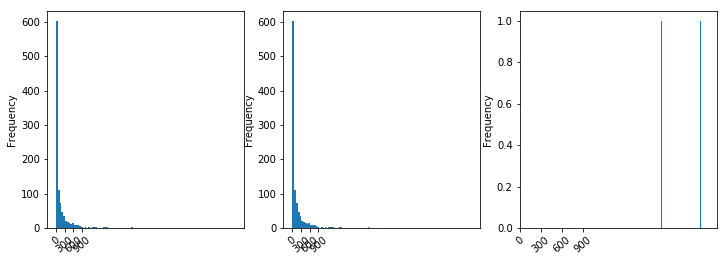

In [288]:
# distribution of restaurants on number of reviews
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
(df_all, df_otr, df_tsr)
for ax, df_temp in zip((ax1, ax2, ax3), (df_all, df_otr, df_tsr)):
    df_temp.groupby('alias').count().ratingValue.sort_values()\
    .plot('hist', bins=100, xticks=range(0, 1000, 300), rot=40, ax=ax)

In [2]:
len(df.alias.unique())

1023

In [140]:
# businesses that has more than 50 reviews
pd_more_than_N_index = (df.groupby('alias').alias.count() > 100)
more_than_N = pd_more_than_N_index[pd_more_than_N_index == True].index
more_than_N

Index(['1054togoshi-kihei', '5-palms-restaurant-kihei-2', '808-deli-kihei',
       '808-grindz-cafe-lahaina-2', '808-on-main-wailuku',
       '808-plates-maui-kahului', 'a-saigon-cafe-wailuku',
       'aa-roots-lahaina-5', 'acevedos-hawaicano-cafe-kahului',
       'akamai-coffee-kahului-4',
       ...
       'vanta-cafe-wailuku-5', 'vietnamese-cuisine-kihei',
       'vietnamese-food-to-go-kihei', 'waihee-ridge-trail-wailuku',
       'waikapu-on-30-wailuku', 'wailele-luau-lahaina-2',
       'wailuku-coffee-company-wailuku', 'what-ales-you-kihei',
       'wow-wee-mauis-kava-bar-and-grill-kahului', 'zippys-kahului-kahului'],
      dtype='object', name='alias', length=343)

In [141]:
# ts restaurants only
more_than_N[more_than_N.isin(ts_restaurants)]

Index(['dukes-beach-house-lahaina', 'hula-grill-kaanapali-lahaina-2',
       'kimos-maui-lahaina', 'leilanis-lahaina-2'],
      dtype='object', name='alias')

In [266]:
# scaling trials and comparisons
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
mm = MinMaxScaler(feature_range=(-1, 1))

scaling_list = []
X = df.groupby('topic_score').mean().sentiment_score.values.reshape(-1, 1)
scaling_list.append(X)
scaling_list.append(sc.fit_transform(X))
scaling_list.append(mm.fit_transform(X))
scaling_list.append(np.vectorize(lambda x: (x*2)-1)(X))
pd.DataFrame(
    data=[i.reshape(1, len(X))[0] for i in scaling_list],
    index=['orginal', 'stdscal', 'minmax', '-1_1']
).transpose().rename(index=str)

,orginal,stdscal,minmax,-1_1
0,0.801150,0.241384,0.238895,0.602300
1,0.854006,0.787706,0.649411,0.708013
2,0.693043,-0.876008,-0.600734,0.386085
3,0.899147,1.254276,1.000000,0.798294
4,0.641635,-1.407358,-1.000000,0.283269


## Division of Categories

- All Businesses
- TS vs Others
- TS only

In [145]:
df_all = df[df.alias.isin(more_than_N)]
df_tsr = df_all[df_all.alias.isin(ts_restaurants) == True]
df_otr = df_all[df_all.alias.isin(ts_restaurants) == False]
dfs = [df_all, df_tsr, df_otr]

In [146]:
[len(i) for i in dfs]

[179739, 9097, 170642]

In [147]:
# adjust sentiment score
adjusted_sent_func = lambda x: (x*2)-1

# helpful for plotting 
plot_params = dict(subplots=False, ylim=(-1,1), rot=45, figsize=(9, 6))

columns = [f'topic_{i}' for i in range(5)]
columns

['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']

## Results Charts for All Categories

### Topic Sentiment Scores

In [148]:
# ts vs others
pd_tsvsothers = df.groupby(by=[df.alias.isin(ts_restaurants), 'topic_score']).sentiment_score.mean().unstack(level=0)# .apply(lambda x: adjusted_sent_func(x)).unstack(level=1).plot(kind='bar')
pd_all = df.groupby(by=df.topic_score).mean().loc[:,['sentiment_score']]

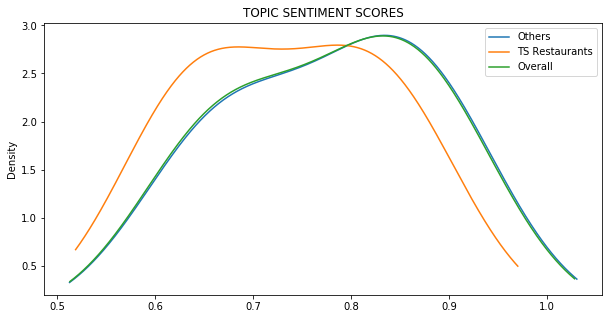

In [149]:
pd_tsvsothers.columns = ['Others', 'TS Restaurants']
pd_all.columns = ['Overall']
pd.concat([pd_tsvsothers, pd_all], axis=1).plot(kind='density', subplots=False, figsize=(10,5), title='topic sentiment scores'.upper())# .legend(bbox_to_anchor=(1, 0.25))

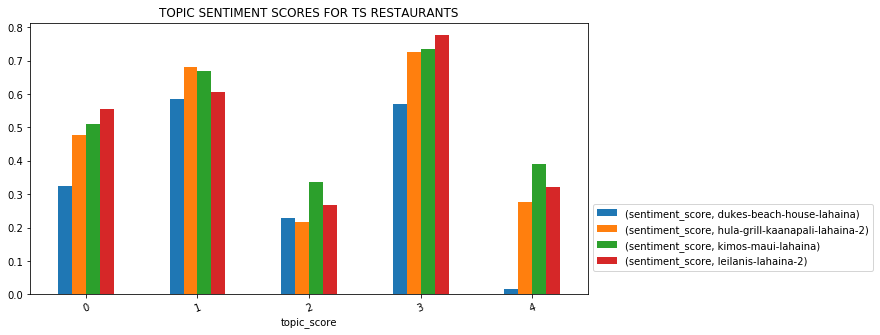

In [150]:
# ts restaurants 
pd_ts_res_only = df_tsr.groupby(by=[df.topic_score, df.alias]).mean().loc[:,['sentiment_score']].apply(lambda x: adjusted_sent_func(x)).unstack(level=1)
pd_ts_res_only.plot(kind='bar', rot=20, figsize=(10,5), title='topic sentiment scores for ts restaurants'.upper()).legend(bbox_to_anchor=(1, 0.35))

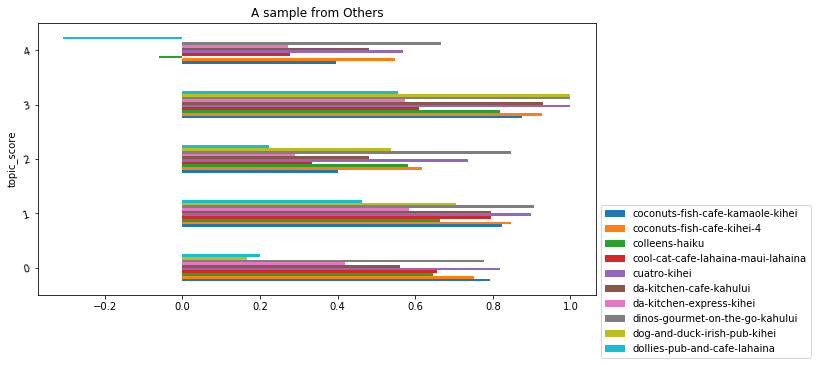

In [158]:
pd_alias_topic = df.groupby(['alias','topic_score']).mean().loc[more_than_N[60:70],['sentiment_score']]
pd_alias_topic['sent_adjusted'] = pd_alias_topic.sentiment_score.apply(lambda x: (x*2)-1)
pd_alias_topic.sent_adjusted.unstack(level=0).plot(kind='barh', subplots=False, rot=15, figsize=(10,5), ylim=(-1,1), title='A sample from Others').legend(bbox_to_anchor=(1, 0.35))

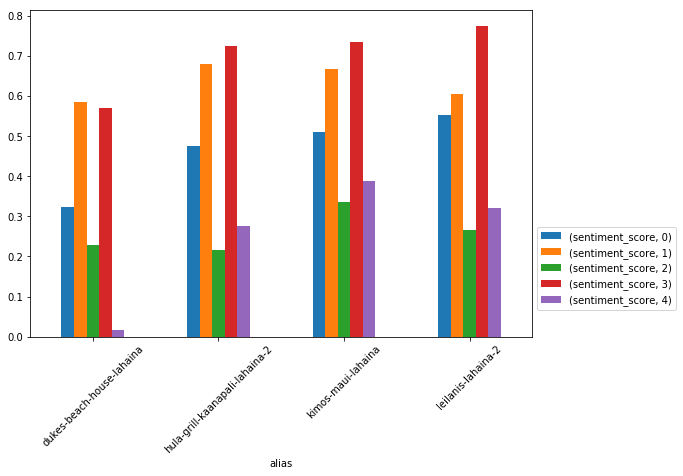

In [100]:
pd_sent_topics = df[df.alias.isin(ts_restaurants)].groupby(['topic_score', 'alias'])\
.mean().loc[:,['sentiment_score']].apply(lambda x: adjusted_sent_func(x))
plot_params['ylim'] = None
pd_sent_topics.unstack(level=0).plot(kind='bar', **plot_params).legend(bbox_to_anchor=(1, 0.35))

### Topic Distribution

In [160]:
columns.append('topic_score')
columns.append('alias')
columns.append('sentiment_score')

In [162]:
df_all.loc[:,columns].groupby(['alias', 'topic_score']).mean()#.loc[:,columns]#.unstack(level=0)

topic_0   topic_1  \
alias                                    topic_score                       
1054togoshi-kihei                        0            3.827586  1.482759   
                                         1            0.964912  3.105263   
                                         2            0.962963  1.444444   
                                         3            1.200000  1.200000   
                                         4            1.500000  2.875000   
5-palms-restaurant-kihei-2               0            3.525424  1.491525   
                                         1            0.861111  3.180556   
                                         2            0.813953  1.224806   
                                         3            0.875000  1.250000   
                                         4            1.200000  1.853846   
808-deli-kihei                           0            2.992126  1.055118   
                                         1            1.265385  2.765385   
                                         2            1.044776  1.029851   
                                         3            1.125000  1.125000   
                                         4            1.333333  1.173913   
808-grindz-cafe-lahaina-2                0            3.365079  1.328042   
                                         1            1.205742  2.929825   
                                         2            0.968750  1.057292   
                                         3            0.933333  0.716667   
                                         4            1.370874  1.553398   
808-on-main-wailuku                      0            3.795455  1.875000   
                                         1            1.256944  2.847222   
                                         2            0.843750  1.218750   
                                         3            1.000000  0.750000   
                                         4            2.488372  2.023256   
808-plates-maui-kahului                  0            3.409836  1.065574   
                                         1            1.428571  2.657143   
                                         2            1.142857  0.928571   
                                         3            1.000000  0.000000   
                                         4            1.875000  1.437500   
...                                                        ...       ...   
waikapu-on-30-wailuku                    0            3.950000  1.725000   
                                         1            1.407895  3.236842   
                                         2            0.727273  0.727273   
                                         3            1.200000  1.400000   
                                         4            2.150000  1.500000   
wailele-luau-lahaina-2                   0            3.000000  0.666667   
                                         1            0.645161  3.258065   
                                         2            0.421053  1.210526   
                                         3            0.666667  0.333333   
                                         4            0.921875  2.437500   
wailuku-coffee-company-wailuku           0            2.684211  1.289474   
                                         1            0.750000  2.741935   
                                         2            0.380952  0.809524   
                                         3            0.516129  1.000000   
                                         4            0.918919  1.432432   
what-ales-you-kihei                      0            2.285714  1.142857   
                                         1            0.592593  3.379630   
                                         2            0.480000  1.560000   
                                         3            1.000000  1.200000   
                                         4            0.730769  1.538462   
wow-wee-mauis-kava-bar-and-

In [123]:
df_otr.ratingValue.mean()

4.072297934344733

In [122]:
df_tsr.ratingValue.mean()

3.8993074639991208